# Evidence 1 - Supervised learning

Paulina Leal Mosqueda, A01659576

Santiago Nava Figueroa, A01174557

Natalie Wilske, A01764862


In [115]:
import sys

assert sys.version_info >= (3, 7)
import pandas as pd

from packaging import version
import sklearn

assert version.parse(sklearn.__version__) >= version.parse("1.0.1")

import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

In [116]:
from pathlib import Path

IMAGES_PATH = Path() / "images" / "decision_trees"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Import dataset and explore it

In [117]:
import openml
import pandas as pd

# Get Dataset from OPENML
dataset = openml.datasets.get_dataset(23)


df, *_ = dataset.get_data()

# Get features as X
X = df.drop('Contraceptive_method_used',axis=1)


# Get class as y
y = df['Contraceptive_method_used']

In [118]:
X

,Wifes_age,Wifes_education,Husbands_education,Number_of_children_ever_born,Wifes_religion,Wifes_now_working%3F,Husbands_occupation,Standard-of-living_index,Media_exposure
0,24,2,3,3,1,1,2,3,0
1,45,1,3,10,1,1,3,4,0
2,43,2,3,7,1,1,3,4,0
3,42,3,2,9,1,1,3,3,0
4,36,3,3,8,1,1,3,2,0
...,...,...,...,...,...,...,...,...,...
1468,33,4,4,2,1,0,2,4,0
1469,33,4,4,3,1,1,1,4,0
1470,39,3,3,8,1,0,1,4,0
1471,33,3,3,4,1,0,2,2,0


In [119]:
y.value_counts()

Contraceptive_method_used
1    629
3    511
2    333
Name: count, dtype: int64

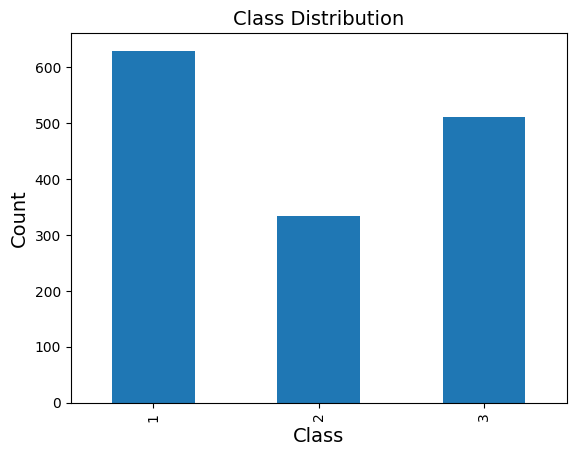

In [120]:
import matplotlib.pyplot as plt

y.value_counts().sort_index().plot(kind='bar')

# Add labels and title
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class Distribution')

plt.show()

In [121]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1473 entries, 0 to 1472
Data columns (total 9 columns):
 #   Column                        Non-Null Count  Dtype   
---  ------                        --------------  -----   
 0   Wifes_age                     1473 non-null   uint8   
 1   Wifes_education               1473 non-null   category
 2   Husbands_education            1473 non-null   category
 3   Number_of_children_ever_born  1473 non-null   uint8   
 4   Wifes_religion                1473 non-null   category
 5   Wifes_now_working%3F          1473 non-null   category
 6   Husbands_occupation           1473 non-null   category
 7   Standard-of-living_index      1473 non-null   category
 8   Media_exposure                1473 non-null   category
dtypes: category(7), uint8(2)
memory usage: 14.2 KB


In [122]:
X.describe()

,Wifes_age,Number_of_children_ever_born
count,1473.000000,1473.000000
mean,32.538357,3.261371
std,8.227245,2.358549
min,16.000000,0.000000
25%,26.000000,1.000000
50%,32.000000,3.000000
75%,39.000000,4.000000
max,49.000000,16.000000


# Description of Dataset
The dataset is focused in predicting contraceptive method choice (no use, long-term methods, or short-term methods) of a woman based on her demographic and socio-economic characteristics. The samples come from a subset of the 1987 National Indonesia Contraceptive Prevalence Survey and they contain married women who were either not pregnant or do not know if they were at the time of interview.

It has 1473 instances with 10 features including the class. Information of the features:

* Wife's age (16-49): numerical
* Wife's education (categorical) 1=low, 2, 3, 4=high
* Husband's education (categorical) 1=low, 2, 3, 4=high
* Number of children ever born (0-16): numerical
* Wife's religion (binary) 0=Non-Islam, 1=Islam
* Wife's now working? (binary) 0=Yes, 1=No
* Husband's occupation (categorical) 1, 2, 3, 4
* Standard-of-living index (categorical) 1=low, 2, 3, 4=high
* Media exposure (binary) 0=Good, 1=Not good
* Contraceptive method used (class attribute) 1=No-use 2=Long-term 3=Short-term

(OpenMl, n.d.)

In this case, the categorical features are set as nominal, but if we observe there are some that may seem as ordinal because they use a low to high scale. For that reason, one of the aims is to treat those features as ordinal and the other is to treat it as nominal. After doing this, the performance will be evaluated to assess which option is the best. There are also no Nan values in the dataset.

As we can see above the classes are a bit unbalanced, because class 1 is 42.7% of the dataset, while class 2 is 34.69% and class 3 is 22.60%. So even if they don't have the same number of samples, they are still close to each other.

# Compare results with OneHotEncoder for the categorical variables
We will use OneHotEncoder for this because it allows us to separate the variables in a way in which we don't give more weight to a value. Since, we're gonna test it with default decisions trees, there is no need in scaling the numeric variables.

# Default Decision Tree
**OneHotEncoder just for Husbands_occupation**

In [123]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder



# Only convert categorical feature of Husband's occupation.
categorical_features = ['Husbands_occupation']
numeric_features = ["Wifes_age", "Number_of_children_ever_born"]  
binary_features = ["Wifes_religion", "Wifes_now_working%3F", "Media_exposure"]
ordinal_features = ["Wifes_education", "Husbands_education", "Standard-of-living_index"]



# Create pipline for categorical vairables (OneHotEncoder)
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'))
])

#OrdinalEncoder
ordinal_transformer = Pipeline(steps=[
    ('ordinal', OrdinalEncoder())
])

#Preprocess
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", categorical_transformer, categorical_features),
        ('binary', 'passthrough', binary_features),
        ('ordinal', ordinal_transformer, ordinal_features),
        ('num', 'passthrough', numeric_features)
    ]
)

pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", DecisionTreeClassifier(random_state=42))
])

# Split dataset

In [124]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Results for Default Tree 
**OneHotEncoder just for Husbands_occupation**

In [125]:
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

print("First example with 'Husbands_occupation':")
print(f"Tree depth: {pipeline.named_steps['classifier'].get_depth()}")
print(classification_report(y_test, y_pred))

First example with 'Husbands_occupation':
Tree depth: 23
              precision    recall  f1-score   support

           1       0.65      0.63      0.64       130
           2       0.43      0.39      0.41        71
           3       0.39      0.43      0.41        94

    accuracy                           0.51       295
   macro avg       0.49      0.48      0.49       295
weighted avg       0.51      0.51      0.51       295



In [126]:
feature_names = pipeline.named_steps['preprocessor'].get_feature_names_out()
print(feature_names)

['cat__Husbands_occupation_2' 'cat__Husbands_occupation_3'
 'cat__Husbands_occupation_4' 'binary__Wifes_religion'
 'binary__Wifes_now_working%3F' 'binary__Media_exposure'
 'ordinal__Wifes_education' 'ordinal__Husbands_education'
 'ordinal__Standard-of-living_index' 'num__Wifes_age'
 'num__Number_of_children_ever_born']


# Default Tree 
**OneHotEncoder for all categorical variables**

In [127]:

categorical_features2 = ["Wifes_education", 'Husbands_occupation', "Husbands_education", "Standard-of-living_index"]
numeric_features = ["Wifes_age", "Number_of_children_ever_born"]  
binary_features = ["Wifes_religion", "Wifes_now_working%3F", "Media_exposure"]


categorical_transformer2 = Pipeline(steps=[
    ('onehot', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'))
])


preprocessor2 = ColumnTransformer(
    transformers=[
        ("cat", categorical_transformer2, categorical_features2),
        ('binary', 'passthrough', binary_features),
        ('num', 'passthrough', numeric_features)
    ]
)

pipeline2 = Pipeline([
    ("preprocessor", preprocessor2),
    ("classifier", DecisionTreeClassifier(random_state=42))
])

pipeline2.fit(X_train, y_train)
y_pred = pipeline2.predict(X_test)

print(f"Tree depth: {pipeline2.named_steps['classifier'].get_depth()}")
print(classification_report(y_test, y_pred))

Tree depth: 20
              precision    recall  f1-score   support

           1       0.61      0.62      0.61       130
           2       0.41      0.39      0.40        71
           3       0.46      0.46      0.46        94

    accuracy                           0.51       295
   macro avg       0.49      0.49      0.49       295
weighted avg       0.51      0.51      0.51       295



In [128]:
from sklearn import set_config
set_config(transform_output='pandas')  # For easier inspection (scikit-learn >=1.2)

X_train_transformed = pipeline.named_steps['preprocessor'].fit_transform(X_train)
print(X_train_transformed.shape)

print("Train accuracy:", pipeline.score(X_train, y_train))
print("Test accuracy:", pipeline.score(X_test, y_test))

(1178, 11)
Train accuracy: 0.9584040747028862
Test accuracy: 0.5084745762711864


Therefore, the results with only the best results are obtained by transforming all the categorical features. It is now possible to create a fine-tuned decision tree by converting the categorical features using OneHotEncoder. Since the maximum depth of the default tree was 20, we'll set the height to 30 to have a margin of error.

Now, we need to decide the performance measure that we'll use. In this case, accuracy is not the best option because the decision will give more weight to class 1, given the initial class distribution that we saw first, which was moderately unbalanced. If we choose precision, we would overlook some of the classes. Thus, the model loses information about the woman's choice based on her characteristics. On the other hand, if we only use recall, the model may misclassify some classes, which would generate false conclusions and ultimately affect the interpretation of how women choose their contraceptive method. Therefore, in this case, the performance measure will be the F1-score because it is the harmonic mean of precision and recall, which means that we will consider both measures. 

Since the dataset is slightly unbalanced we'll use stratified folds, so that the folds contain a representative ratio of each class.

# Preprocessing


In [129]:
# Convert all categorical with One Hot Encoder
categorical_features = ["Wifes_education", 'Husbands_occupation', "Husbands_education", "Standard-of-living_index"]
numeric_features = ["Wifes_age", "Number_of_children_ever_born"]  
binary_features = ["Wifes_religion", "Wifes_now_working%3F", "Media_exposure"]


# Create pipline for categorical vairables (OneHotEncoder)
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'))
])

#OrdinalEncoder
ordinal_transformer = Pipeline(steps=[
    ('ordinal', OrdinalEncoder())
])

#Preprocess
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", categorical_transformer, categorical_features),
        ('binary', 'passthrough', binary_features),
        ('num', 'passthrough', numeric_features)
    ]
)


# Decision Tree

In [130]:
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import classification_report


cv = RepeatedStratifiedKFold(n_splits=20, n_repeats=10, random_state=42)



param_grid = {
    'classifier__max_depth': [None, 5, 10, 30],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4],
    'classifier__criterion': ['gini', 'entropy']
}

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(random_state=42))
])


grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring='f1_weighted',  
    cv=cv,
    n_jobs=-1 
)

grid_search.fit(X_train, y_train)

best_tree = grid_search.best_estimator_


y_pred = best_tree.predict(X_test)

print(classification_report(y_test, y_pred))
print("Best parameters:", grid_search.best_params_)
print("Best weighted F1 score:", grid_search.best_score_)

              precision    recall  f1-score   support

           1       0.73      0.54      0.62       130
           2       0.56      0.42      0.48        71
           3       0.44      0.68      0.54        94

    accuracy                           0.56       295
   macro avg       0.58      0.55      0.55       295
weighted avg       0.60      0.56      0.56       295

Best parameters: {'classifier__criterion': 'gini', 'classifier__max_depth': 5, 'classifier__min_samples_leaf': 4, 'classifier__min_samples_split': 10}
Best weighted F1 score: 0.5528766823464109


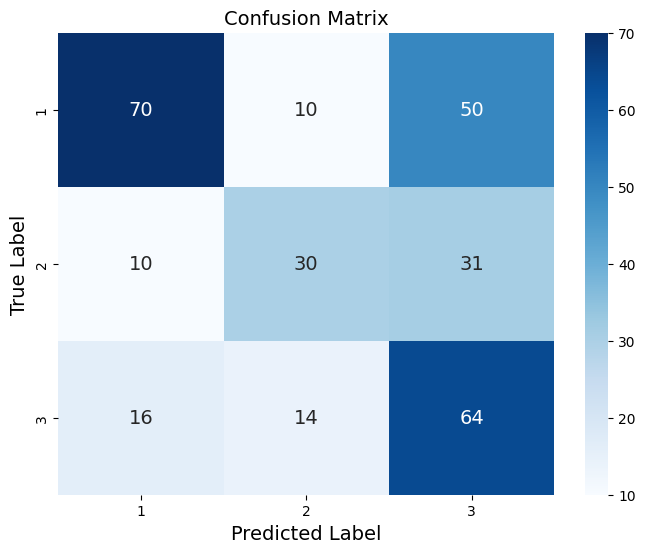

In [131]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


y_pred = best_tree.predict(X_test)


cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=["1", "2", "3"], 
            yticklabels=["1", "2", "3"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

The decision tree has better results for class 1 because there were more instances in comparison to the others. However, there are 50 instances that are being classified as false positives since they belonged to class 3. Moreover, class 2 has lower true positives, which means that the model struggles to identify the women who use long-term contraceptives. In this case, the model also has more false positives than class 3. This suggests that the model is producing several false positives that belonged to class 3. Moreover, most of the instances for class 3 were correctly classified, although there are some exceptions. In general, the decision tree performs better for class one.

In [132]:
best_dt = best_tree.named_steps['classifier']
feature_names = best_tree.named_steps['preprocessor'].get_feature_names_out()


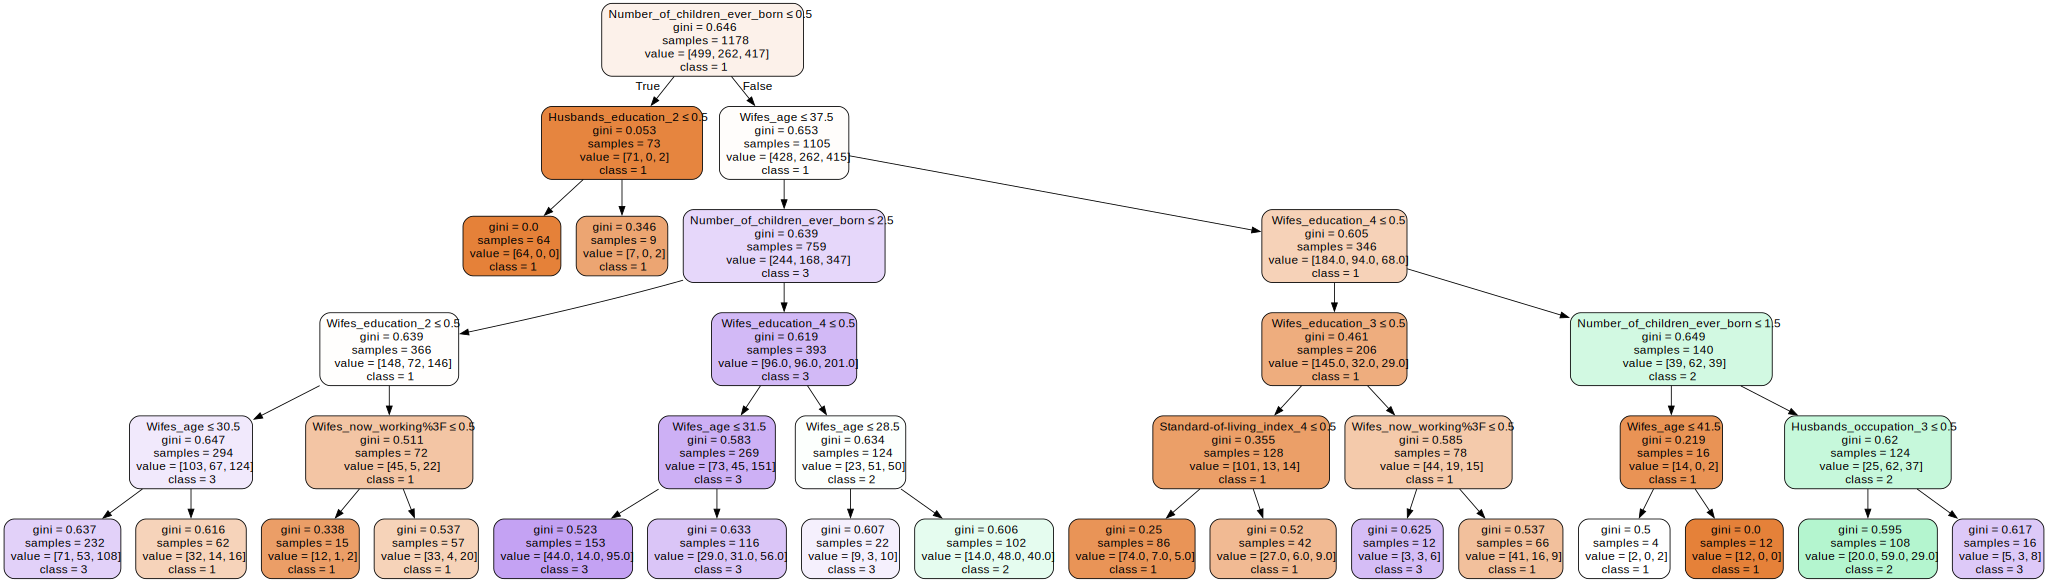

In [133]:
from sklearn.tree import export_graphviz
from graphviz import Source


feature_names = best_tree.named_steps['preprocessor'].get_feature_names_out()

dot_path = IMAGES_PATH / "best_tree.dot"


clean_feature_names = []
for name in feature_names:
    clean_name = name.split('__')[-1]
    clean_feature_names.append(clean_name)



export_graphviz(
    best_dt,
    out_file=str(dot_path),
    feature_names=clean_feature_names,  
    class_names=["1", "2", "3"],
    rounded=True,
    filled=True,
    special_characters=True,
)


Source.from_file(dot_path)

We chose 20 splits for RepeatedStratifiedKFold because this combination gave the best result for the F1 score after trying different values. Moreover, the maximum depth for the parameter of the GridSearch was 30 because the default tree had a maximum height of 23. We used a weighted F1 score to balance precision and recall, ensuring the dataset is representative and avoiding bias towards class one. This ensures that all targets are taken into account and that the minority classes are not being overshadowed. 

The results indicate that the model continues to favour class one, achieving the highest scores across all performance measures. This bias may come from the original dataset's limit size of 1473 samples and the restricted number of features, which totals only 10, including the class label.

# Gradient Boosting Classifier
Natalie Wilske

Gradient Boosting (GB) is a supervised ensemble learning algorithm used for regression and classification tasks. It builds a strong predictive model by sequentially combining multiple weak learners (typically shallow decision trees), each correcting the errors of its predecessor. Unlike bagging (e.g., Random Forests), GB focuses on iterative error minimization through gradient descent optimization, making it highly effective for complex datasets.

Advantages
* High Accuracy: State-of-the-art performance on tabular data, often outperforming Random Forests and SVMs.
* Flexibility: Supports custom loss functions (e.g., MSE, log-loss) and handles mixed data types (with preprocessing).
* Feature Importance: Provides interpretable metrics on feature contributions.
* Robustness: Automatically handles feature interactions and missing values.

Disadvantages
* Computational Cost: Sequential training is slow and resource-intensive.
* Hyperparameter Sensitivity: Requires tuning of learning rate, tree depth, and tree count to avoid overfitting.
* Overfitting Risk: High model complexity without regularization (e.g., small η or tree constraints).
* Black-Box Nature: Harder to interpret than single decision trees.

## **Gradient Boosting Parameters:**
* **n_estimators:** This specifies the number of trees (estimators) to be built. A higher value typically improves model performance but increases computation time.
* **learning_rate:** This is the shrinkage parameter. It scales the contribution of each tree.
* **random_state:** It ensures reproducibility of results. Setting a fixed value for random_state ensure that you get the same results every time you run the model.
* **max_depth:** Controls the maximum depth of each tree, limiting how many splits it can make. Lower values prevent overfitting but may underfit, while higher values capture more complexity at risk of overfitting.
* **min_samples_split:** Sets the minimum number of samples required to split an internal node. Higher values constrain tree growth (reducing overfitting), while lower values allow finer splits.
* **min_samples_leaf:** Defines the minimum samples that must remain in a leaf node after splitting. Higher values create smoother boundaries (improving generalization), while lower values permit more granular leaves.

In [134]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, f1_score

In [135]:
# Convert all categorical with One Hot Encoder
categorical_features = ["Wifes_education", 'Husbands_occupation', "Husbands_education", "Standard-of-living_index"]
numeric_features = ["Wifes_age", "Number_of_children_ever_born"]  
binary_features = ["Wifes_religion", "Wifes_now_working%3F", "Media_exposure"]


# Create pipline for categorical vairables (OneHotEncoder)
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'))
])

# Scale numeric variables
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

#OrdinalEncoder
ordinal_transformer = Pipeline(steps=[
    ('ordinal', OrdinalEncoder())
])

#Preprocess
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", categorical_transformer, categorical_features),
        ('binary', 'passthrough', binary_features),
        ('num', numeric_transformer, numeric_features),
    ]
)

In [136]:
# Create pipeline
gb_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', GradientBoostingClassifier(random_state=42))
])

# Define parameter grid
param_grid = {
    'classifier__n_estimators': [50, 100, 200],
    'classifier__learning_rate': [0.01, 0.1, 0.2],
    'classifier__max_depth': [3, 4, 5],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4]
}

# Setup cross-validation
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=5, random_state=42)

# Grid search
grid_search_gb = GridSearchCV(
    estimator=gb_pipeline,
    param_grid=param_grid,
    scoring='f1_weighted',
    cv=cv,
    n_jobs=-1,
    verbose=1
)

grid_search_gb.fit(X_train, y_train)

# Get best model
best_gb = grid_search_gb.best_estimator_

# Evaluate
y_pred_gb = best_gb.predict(X_test)

print("Gradient Boosting Classifier Results:")
print("Best parameters:", grid_search_gb.best_params_)
print(classification_report(y_test, y_pred_gb))
print("Best test F1 score:", f1_score(y_test, y_pred_gb, average='weighted'))

Fitting 50 folds for each of 243 candidates, totalling 12150 fits
Gradient Boosting Classifier Results:
Best parameters: {'classifier__learning_rate': 0.01, 'classifier__max_depth': 3, 'classifier__min_samples_leaf': 4, 'classifier__min_samples_split': 10, 'classifier__n_estimators': 200}
              precision    recall  f1-score   support

           1       0.78      0.62      0.69       130
           2       0.68      0.38      0.49        71
           3       0.50      0.81      0.62        94

    accuracy                           0.62       295
   macro avg       0.65      0.60      0.60       295
weighted avg       0.66      0.62      0.62       295

Best test F1 score: 0.6165838224394682


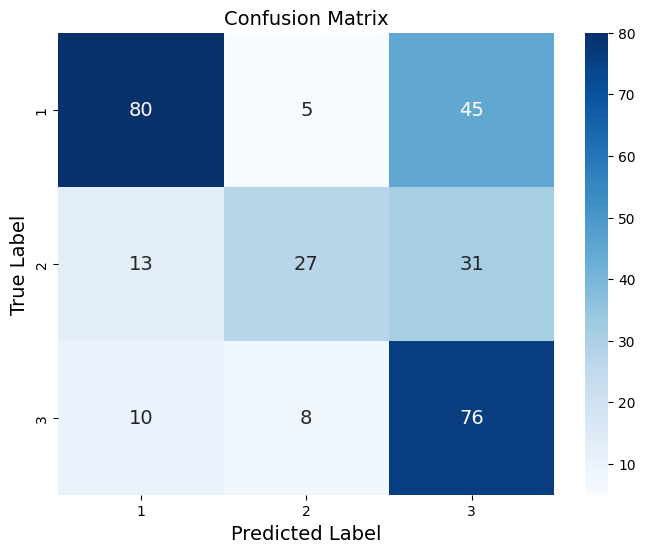

In [137]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred_gb)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=["1", "2", "3"], 
            yticklabels=["1", "2", "3"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [138]:
# Results from training and testing
# See if there's any overfitting

# Train the model with X_train
y_train_pred_gb = best_gb.predict(X_train)


print("\nClassification report on training set:")
print(classification_report(y_train, y_train_pred_gb))

# F1 scores for comparison
train_f1 = f1_score(y_train, y_train_pred_gb, average='weighted')
test_f1 = f1_score(y_test, y_pred_gb, average='weighted')

print(f"Train f1_score: {train_f1}")
print(f"Test  f1_score: {test_f1}")


Classification report on training set:
              precision    recall  f1-score   support

           1       0.71      0.64      0.67       499
           2       0.56      0.37      0.44       262
           3       0.52      0.69      0.59       417

    accuracy                           0.60      1178
   macro avg       0.60      0.57      0.57      1178
weighted avg       0.61      0.60      0.59      1178

Train f1_score: 0.5933814150900791
Test  f1_score: 0.6165838224394682


# References

* GeeksforGeeks. "ML | Gradient Boosting." (https://www.geeksforgeeks.org/machine-learning/ml-gradient-boosting/)
* IBM. "What Is Gradient Boosting?" (https://www.ibm.com/think/topics/gradient-boosting)
* ScikitLearn. "GradientBoostingClassifier" (https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html#sklearn.ensemble.GradientBoostingClassifier)